# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

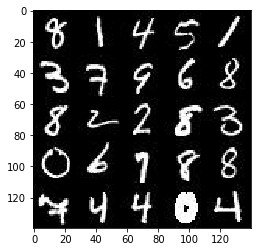

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

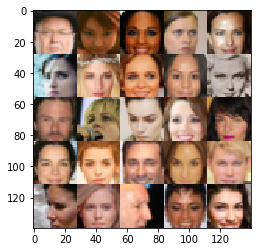

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],
                                name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/riei1/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/riei1/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/riei1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/riei1/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/riei1/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/riei1/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xin_channel_dim
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
tf.reset_default_graph()

In [12]:
import pickle as pkl

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_n_images = 25
    print_every = 10
    show_every = 100
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Rescale batch_images range from -0.5 and 0.5 to -1 to +1 so that it aligns with tanh output
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)

        saver.save(sess, './checkpoints/' + data_image_mode + '_generator.ckpt')

    with open(data_image_mode + '_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    with open(data_image_mode + '_losses.pkl', 'wb') as f:
        pkl.dump(losses, f)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4221... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 0.1453... Generator Loss: 2.7779
Epoch 1/2... Discriminator Loss: 0.3185... Generator Loss: 2.4956
Epoch 1/2... Discriminator Loss: 0.0423... Generator Loss: 6.7987
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 13.7058
Epoch 1/2... Discriminator Loss: 0.1649... Generator Loss: 11.8546
Epoch 1/2... Discriminator Loss: 0.4300... Generator Loss: 3.4020
Epoch 1/2... Discriminator Loss: 0.3467... Generator Loss: 2.0039
Epoch 1/2... Discriminator Loss: 0.2530... Generator Loss: 2.7456
Epoch 1/2... Discriminator Loss: 0.8641... Generator Loss: 4.2894


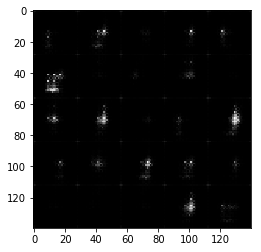

Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 2.0408
Epoch 1/2... Discriminator Loss: 0.5137... Generator Loss: 6.8220
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.4183
Epoch 1/2... Discriminator Loss: 1.9521... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 0.5917... Generator Loss: 1.5463
Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 1.2985
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 0.2557... Generator Loss: 4.7075
Epoch 1/2... Discriminator Loss: 1.6704... Generator Loss: 0.3341
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 1.5473


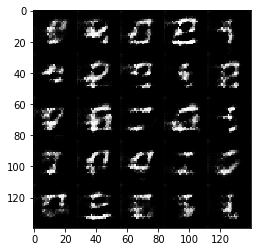

Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 3.0499... Generator Loss: 0.0727
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 1.2594
Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 0.5311... Generator Loss: 2.0908
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 2.6364
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 1.3607


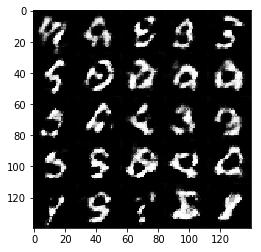

Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 2.3483
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.5678
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.3991


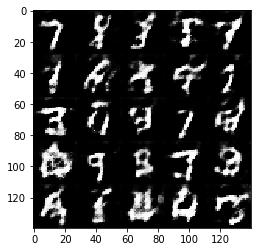

Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 1.8955
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 0.8299... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 1.6597
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 0.9251... Generator Loss: 0.9588


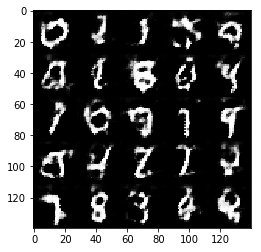

Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 1.7344
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 2.2325
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.4922
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 0.9429
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.5153


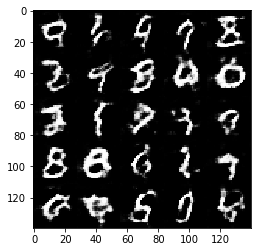

Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 0.7028
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 0.7865... Generator Loss: 1.6264
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.2700
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 0.8604
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 0.6427
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.4893


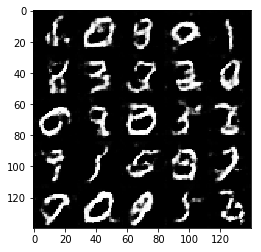

Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.4704
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 1.9423
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.4252
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 1.2795


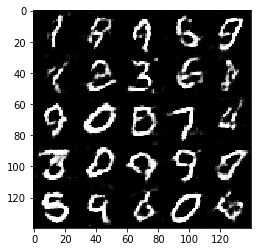

Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.5831
Epoch 1/2... Discriminator Loss: 0.6927... Generator Loss: 2.0434
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 0.7117
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 1.2183
Epoch 1/2... Discriminator Loss: 0.9090... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 1.0480


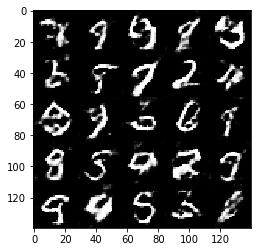

Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.5691
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 1.7331
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 1.2701
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 2.1723
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 1.1110
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.0595
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.4316
Epoch 1/2... Discriminator Loss: 0.9397... Generator Loss: 0.7795


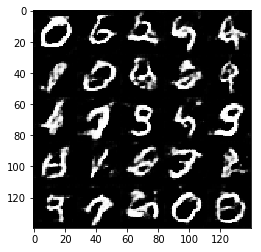

Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 1.6486
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 0.5142
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 0.6022
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 0.3519
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 2.4666... Generator Loss: 3.3424
Epoch 1/2... Discriminator Loss: 0.8474... Generator Loss: 1.4172
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.1646


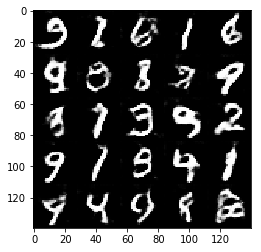

Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 2.0580
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 1.6215
Epoch 1/2... Discriminator Loss: 2.7226... Generator Loss: 0.1179
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.3496
Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 1.3310
Epoch 1/2... Discriminator Loss: 0.5913... Generator Loss: 1.2743
Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 0.6844


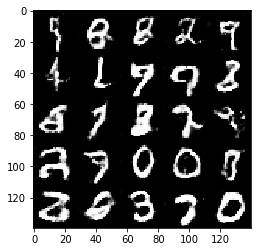

Epoch 1/2... Discriminator Loss: 0.8084... Generator Loss: 1.4919
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.3893
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 1.8397
Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 0.9617
Epoch 1/2... Discriminator Loss: 1.9072... Generator Loss: 0.2408
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.5472
Epoch 1/2... Discriminator Loss: 1.5376... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.5057
Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.4465
Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 1.2298


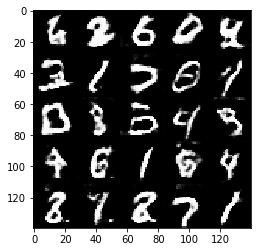

Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 2.3861
Epoch 1/2... Discriminator Loss: 1.6235... Generator Loss: 0.2644
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 2.8523
Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 1.6152
Epoch 1/2... Discriminator Loss: 0.6732... Generator Loss: 1.5306
Epoch 1/2... Discriminator Loss: 0.8217... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 0.7378... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 0.6607... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 0.7509


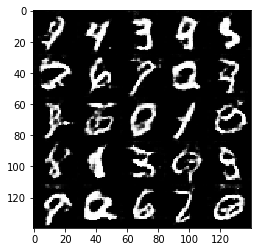

Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.2009
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.4769
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 0.4423... Generator Loss: 2.2002
Epoch 1/2... Discriminator Loss: 3.5946... Generator Loss: 5.6613
Epoch 1/2... Discriminator Loss: 1.0699... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 0.5656... Generator Loss: 1.4057
Epoch 1/2... Discriminator Loss: 1.4931... Generator Loss: 0.3144


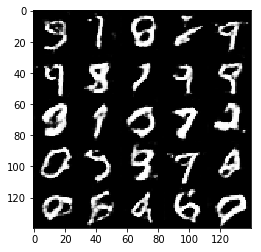

Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 1.8370... Generator Loss: 0.2383
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 2.7326
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 1.1788
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 0.6863... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 1.6995... Generator Loss: 0.2614
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 1.0067


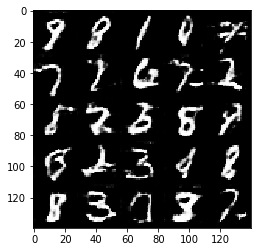

Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 1.7327... Generator Loss: 3.2549
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 1.8611
Epoch 1/2... Discriminator Loss: 0.8693... Generator Loss: 0.7881
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 0.5349... Generator Loss: 1.9247
Epoch 1/2... Discriminator Loss: 1.9903... Generator Loss: 0.2497
Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 1.2820
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.6899


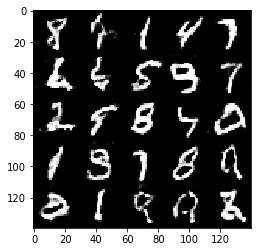

Epoch 1/2... Discriminator Loss: 0.7800... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 0.4969... Generator Loss: 1.3276
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 0.5426... Generator Loss: 1.3745
Epoch 1/2... Discriminator Loss: 2.4581... Generator Loss: 0.1432
Epoch 1/2... Discriminator Loss: 0.6684... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 1.5819... Generator Loss: 0.3144
Epoch 1/2... Discriminator Loss: 2.7120... Generator Loss: 0.1649
Epoch 1/2... Discriminator Loss: 0.8936... Generator Loss: 0.8169


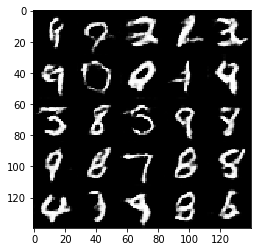

Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 1.0410
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 0.2924... Generator Loss: 1.9079
Epoch 1/2... Discriminator Loss: 0.3670... Generator Loss: 2.8268
Epoch 1/2... Discriminator Loss: 0.4654... Generator Loss: 1.5142
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 2.8766
Epoch 2/2... Discriminator Loss: 2.6524... Generator Loss: 0.4497
Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 1.1567


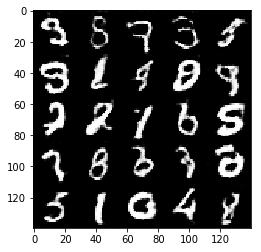

Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.4187
Epoch 2/2... Discriminator Loss: 0.5828... Generator Loss: 1.2668
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.5591
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.1065
Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 0.8966
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 0.6226... Generator Loss: 1.0504


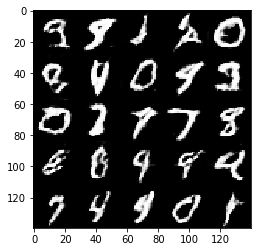

Epoch 2/2... Discriminator Loss: 0.5581... Generator Loss: 1.2018
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.4267
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 0.5627... Generator Loss: 3.0571
Epoch 2/2... Discriminator Loss: 0.6658... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 1.0119
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 2.3451... Generator Loss: 0.2231
Epoch 2/2... Discriminator Loss: 0.7753... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 0.8822


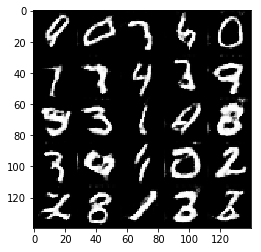

Epoch 2/2... Discriminator Loss: 0.5933... Generator Loss: 1.3062
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.1651
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 3.4477
Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 1.3499
Epoch 2/2... Discriminator Loss: 0.5268... Generator Loss: 1.5588
Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 3.6868
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.3126
Epoch 2/2... Discriminator Loss: 0.5429... Generator Loss: 1.2818
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.5524


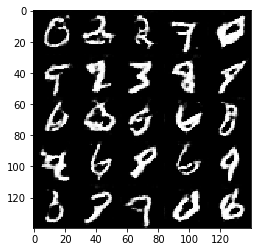

Epoch 2/2... Discriminator Loss: 1.2591... Generator Loss: 0.4767
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 1.4895
Epoch 2/2... Discriminator Loss: 1.7517... Generator Loss: 0.3493
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 0.8615
Epoch 2/2... Discriminator Loss: 0.6415... Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 1.4149
Epoch 2/2... Discriminator Loss: 0.3000... Generator Loss: 1.7787
Epoch 2/2... Discriminator Loss: 1.1139... Generator Loss: 0.5475


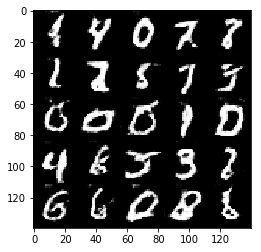

Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 0.9819
Epoch 2/2... Discriminator Loss: 2.1465... Generator Loss: 4.4421
Epoch 2/2... Discriminator Loss: 0.5708... Generator Loss: 1.3421
Epoch 2/2... Discriminator Loss: 0.6570... Generator Loss: 1.1039
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.5704
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 0.5354... Generator Loss: 1.2244
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.1104
Epoch 2/2... Discriminator Loss: 0.4574... Generator Loss: 1.5353
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 0.8442


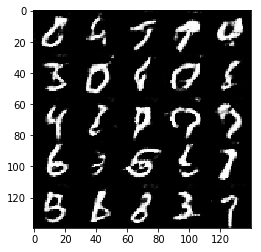

Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 0.4244... Generator Loss: 1.6740
Epoch 2/2... Discriminator Loss: 0.5792... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 1.1727
Epoch 2/2... Discriminator Loss: 2.0667... Generator Loss: 5.2444
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 2.5825
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 1.6732... Generator Loss: 0.4131
Epoch 2/2... Discriminator Loss: 0.4473... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 0.9019


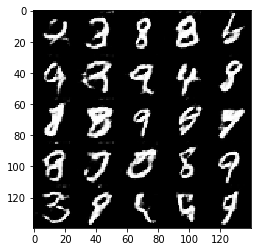

Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 0.7490
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 0.9409
Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.3519
Epoch 2/2... Discriminator Loss: 0.3126... Generator Loss: 2.5401
Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 1.2773
Epoch 2/2... Discriminator Loss: 0.2696... Generator Loss: 2.2306
Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 1.4000
Epoch 2/2... Discriminator Loss: 1.0584... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 0.4768... Generator Loss: 2.9700
Epoch 2/2... Discriminator Loss: 3.0095... Generator Loss: 5.5055


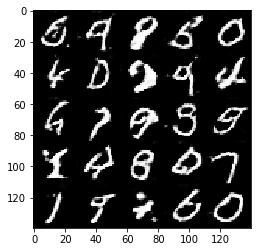

Epoch 2/2... Discriminator Loss: 0.6199... Generator Loss: 1.5362
Epoch 2/2... Discriminator Loss: 0.5740... Generator Loss: 1.3482
Epoch 2/2... Discriminator Loss: 0.3335... Generator Loss: 1.6989
Epoch 2/2... Discriminator Loss: 0.5015... Generator Loss: 2.4486
Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 2.3808
Epoch 2/2... Discriminator Loss: 0.3469... Generator Loss: 3.2662
Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 0.5197... Generator Loss: 2.5295
Epoch 2/2... Discriminator Loss: 0.8579... Generator Loss: 0.8958


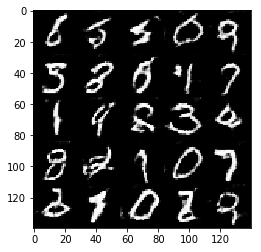

Epoch 2/2... Discriminator Loss: 0.6467... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 2.6271... Generator Loss: 0.1607
Epoch 2/2... Discriminator Loss: 1.3201... Generator Loss: 0.4735
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 0.7707
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 0.4439... Generator Loss: 1.5645
Epoch 2/2... Discriminator Loss: 0.3700... Generator Loss: 1.6297
Epoch 2/2... Discriminator Loss: 0.4452... Generator Loss: 1.2844


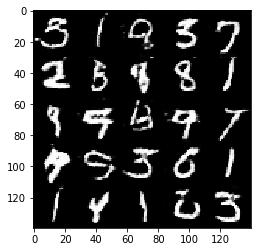

Epoch 2/2... Discriminator Loss: 1.5961... Generator Loss: 0.4741
Epoch 2/2... Discriminator Loss: 0.4735... Generator Loss: 1.5666
Epoch 2/2... Discriminator Loss: 0.5723... Generator Loss: 1.3261
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.0375
Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 1.0931
Epoch 2/2... Discriminator Loss: 0.4938... Generator Loss: 1.6029
Epoch 2/2... Discriminator Loss: 0.5200... Generator Loss: 1.8968
Epoch 2/2... Discriminator Loss: 0.3156... Generator Loss: 2.1238
Epoch 2/2... Discriminator Loss: 0.6071... Generator Loss: 1.2783


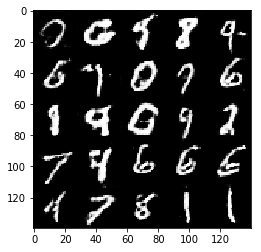

Epoch 2/2... Discriminator Loss: 1.8479... Generator Loss: 0.3386
Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.4296
Epoch 2/2... Discriminator Loss: 0.4062... Generator Loss: 2.4469
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.1336
Epoch 2/2... Discriminator Loss: 0.4277... Generator Loss: 1.7056
Epoch 2/2... Discriminator Loss: 3.9388... Generator Loss: 5.9381
Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 1.3129
Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 1.8017
Epoch 2/2... Discriminator Loss: 0.3676... Generator Loss: 1.5864


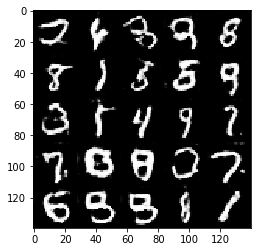

Epoch 2/2... Discriminator Loss: 0.3169... Generator Loss: 1.8062
Epoch 2/2... Discriminator Loss: 1.8649... Generator Loss: 0.2889
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.5485
Epoch 2/2... Discriminator Loss: 0.4359... Generator Loss: 1.4068
Epoch 2/2... Discriminator Loss: 0.3258... Generator Loss: 1.8853
Epoch 2/2... Discriminator Loss: 0.3579... Generator Loss: 1.8634
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.4576
Epoch 2/2... Discriminator Loss: 0.2428... Generator Loss: 2.0822
Epoch 2/2... Discriminator Loss: 0.4515... Generator Loss: 1.3985
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 0.8985


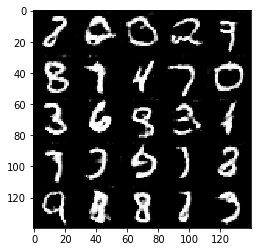

Epoch 2/2... Discriminator Loss: 0.3516... Generator Loss: 1.6802
Epoch 2/2... Discriminator Loss: 0.2340... Generator Loss: 2.9322
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.0943
Epoch 2/2... Discriminator Loss: 0.7764... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 2.3556... Generator Loss: 6.5274
Epoch 2/2... Discriminator Loss: 0.6312... Generator Loss: 2.9197
Epoch 2/2... Discriminator Loss: 0.5303... Generator Loss: 1.5515
Epoch 2/2... Discriminator Loss: 0.3826... Generator Loss: 1.6921
Epoch 2/2... Discriminator Loss: 0.6431... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 0.5288... Generator Loss: 1.3112


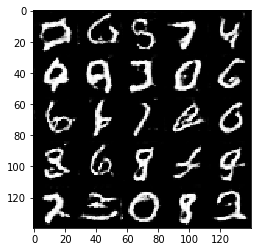

Epoch 2/2... Discriminator Loss: 0.2755... Generator Loss: 2.0212
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.1972
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 2.9233
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 1.3112
Epoch 2/2... Discriminator Loss: 0.5953... Generator Loss: 1.1489
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.5283
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 1.9993
Epoch 2/2... Discriminator Loss: 0.4175... Generator Loss: 1.4770
Epoch 2/2... Discriminator Loss: 0.4479... Generator Loss: 1.5899


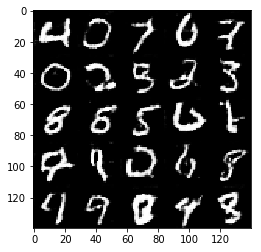

Epoch 2/2... Discriminator Loss: 0.4538... Generator Loss: 2.6266
Epoch 2/2... Discriminator Loss: 0.4418... Generator Loss: 2.3885
Epoch 2/2... Discriminator Loss: 0.5855... Generator Loss: 1.0690
Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 1.1039
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.7273... Generator Loss: 0.3334
Epoch 2/2... Discriminator Loss: 1.7070... Generator Loss: 0.3353
Epoch 2/2... Discriminator Loss: 0.3188... Generator Loss: 2.0483


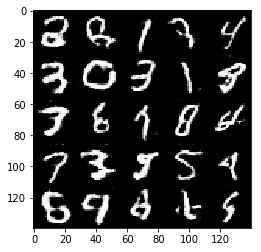

Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.4943
Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 1.1600
Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 0.3243... Generator Loss: 1.6011
Epoch 2/2... Discriminator Loss: 0.2371... Generator Loss: 1.9816
Epoch 2/2... Discriminator Loss: 0.4432... Generator Loss: 1.2962
Epoch 2/2... Discriminator Loss: 0.9508... Generator Loss: 0.6684
Epoch 2/2... Discriminator Loss: 0.3864... Generator Loss: 1.7912
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 1.9566
Epoch 2/2... Discriminator Loss: 0.5129... Generator Loss: 1.2904


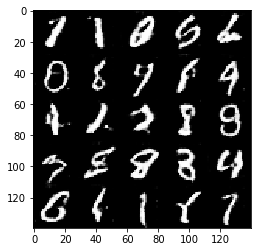

Epoch 2/2... Discriminator Loss: 0.2371... Generator Loss: 2.9199
Epoch 2/2... Discriminator Loss: 0.2540... Generator Loss: 2.0328
Epoch 2/2... Discriminator Loss: 0.4243... Generator Loss: 1.4593
Epoch 2/2... Discriminator Loss: 0.2913... Generator Loss: 1.9495
Epoch 2/2... Discriminator Loss: 1.0717... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 0.4612
Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 1.2907
Epoch 2/2... Discriminator Loss: 0.2887... Generator Loss: 1.9263
Epoch 2/2... Discriminator Loss: 0.2733... Generator Loss: 1.8530
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.1282


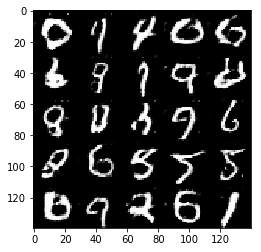

Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 1.0004
Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 0.1316... Generator Loss: 3.3517
Epoch 2/2... Discriminator Loss: 0.1712... Generator Loss: 2.4195
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 0.6196
Epoch 2/2... Discriminator Loss: 0.3398... Generator Loss: 1.7453
Epoch 2/2... Discriminator Loss: 0.1257... Generator Loss: 3.1534
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 2.2949
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 4.6550
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.2700


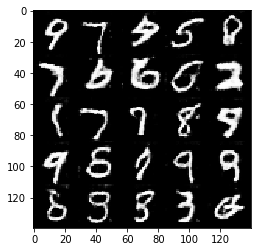

Epoch 2/2... Discriminator Loss: 0.3473... Generator Loss: 2.4555
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 0.7228
Epoch 2/2... Discriminator Loss: 0.4429... Generator Loss: 1.5119
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.4810
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 0.8210


In [19]:
batch_size = 32
z_dim = 90
learning_rate = 0.0006
beta1 = 0.49


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 0.2039... Generator Loss: 13.8668
Epoch 1/1... Discriminator Loss: 0.1019... Generator Loss: 13.9108
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 13.1391
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 2.4641
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 8.9913
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 3.7471
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 1.9324
Epoch 1/1... Discriminator Loss: 0.2554... Generator Loss: 3.2418
Epoch 1/1... Discriminator Loss: 0.2071... Generator Loss: 5.9063


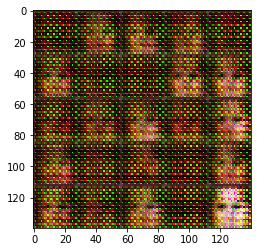

Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 2.9631
Epoch 1/1... Discriminator Loss: 0.3210... Generator Loss: 2.7521
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 5.2969... Generator Loss: 15.3821
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 2.7892
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 6.4313


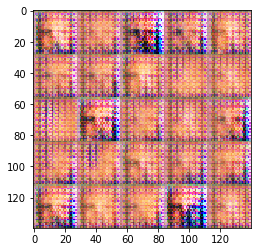

Epoch 1/1... Discriminator Loss: 0.1989... Generator Loss: 3.2604
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 3.1196
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 1.9260
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 1.4910
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 2.6493
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 1.8152
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 1.9916
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 1.6081
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 2.2916
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.2180


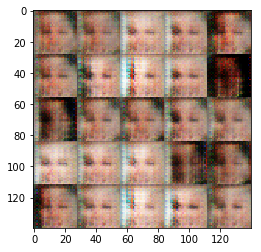

Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 4.0903
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.4850
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 2.2381... Generator Loss: 2.4688
Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 2.9954
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 1.5661
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.5729


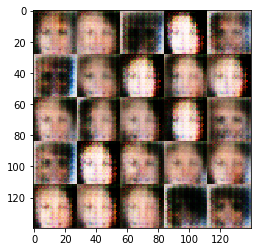

Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.8190
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 1.9031... Generator Loss: 0.2960
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5925


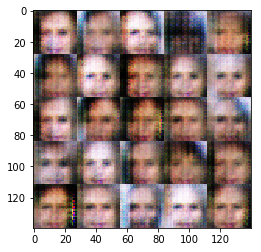

Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.5231
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.7466... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.6145


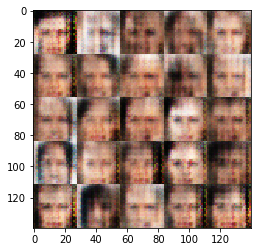

Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 2.1353
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 1.5376
Epoch 1/1... Discriminator Loss: 2.1410... Generator Loss: 0.1871
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 1.6318
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.9574
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.4114


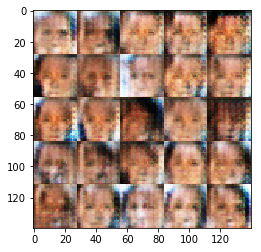

Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.5202
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 2.7132
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.6125


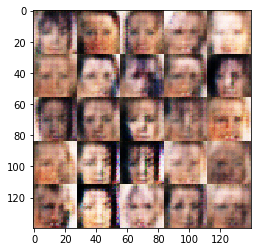

Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.7833


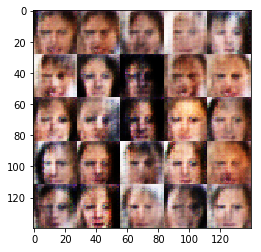

Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.3495
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 1.8945
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.3951
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.8934


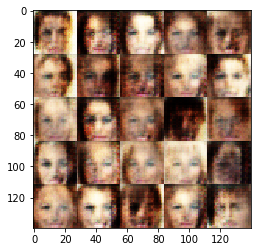

Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.7997
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.6051


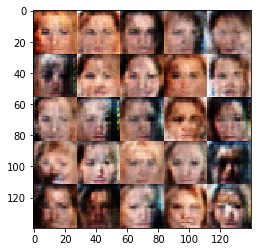

Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 1.4523
Epoch 1/1... Discriminator Loss: 1.8607... Generator Loss: 0.2339
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.7512
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.5483


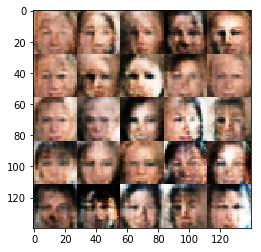

Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 0.8455


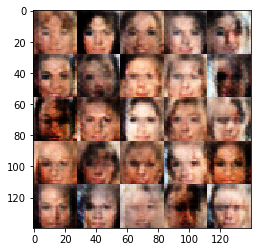

Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 1.1764


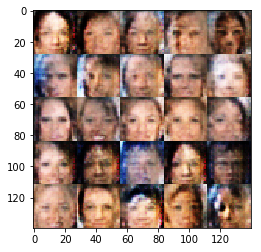

Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.6338... Generator Loss: 0.3023
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.5766


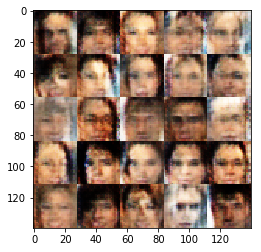

Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.9324


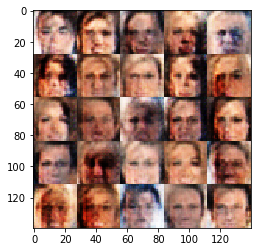

Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.9949


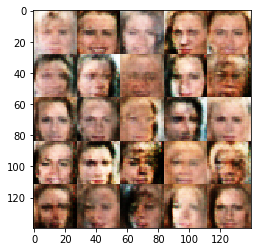

Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.1533


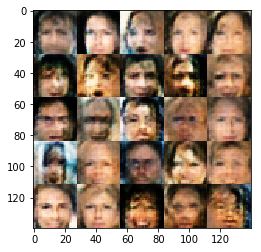

Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 1.2394


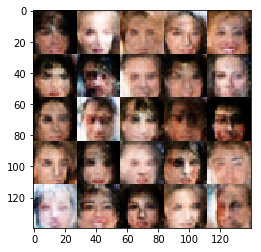

Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.4093
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.1200


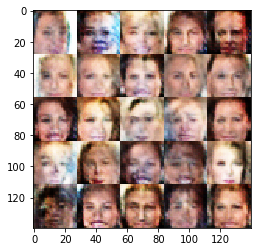

Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.7687
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.1515


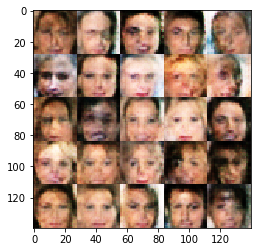

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.3414


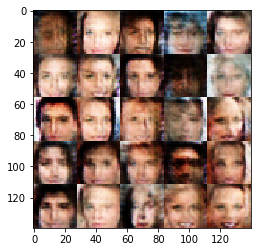

Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.4061
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.7068


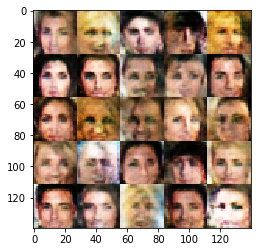

Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 1.5729
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.5608


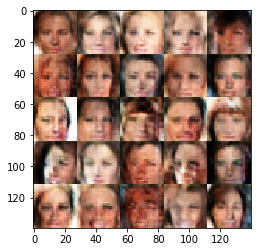

Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.7855


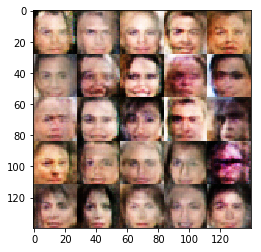

Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.9309


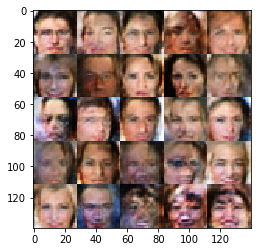

Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 1.6759
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.8611


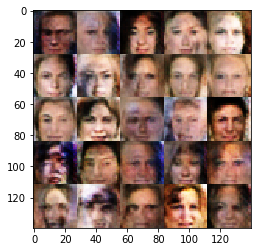

Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.3736
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 1.8216
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.4041


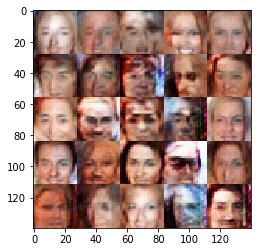

Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.6752


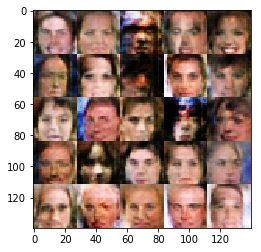

Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.3232
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.6630


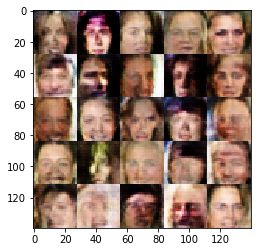

Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.7446... Generator Loss: 0.3523
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.7758
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.3916
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.3719
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7078


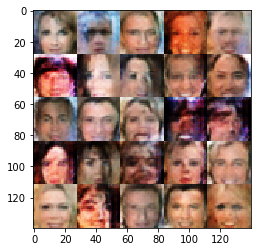

Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.2296
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.3280
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 1.9777


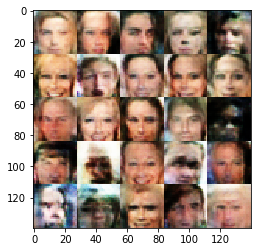

Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.4881


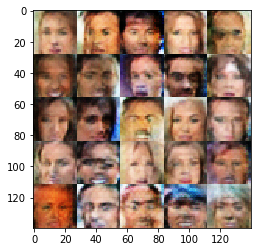

Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.2751
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.5091
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.1660


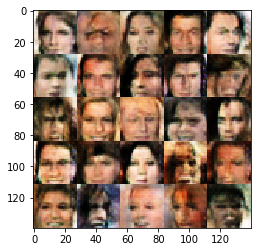

Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8566


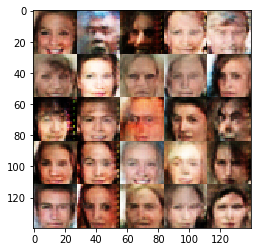

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.6637... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.6832


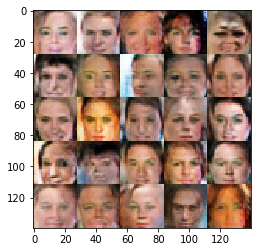

Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.3861
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.3072
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 0.8318


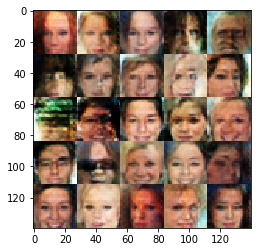

Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.9265


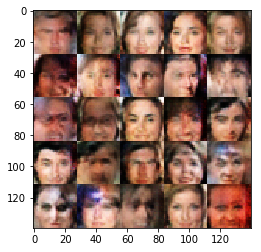

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.4721


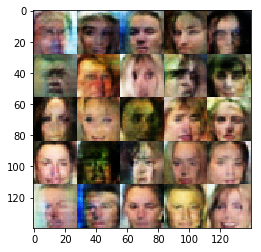

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.3946
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.9677


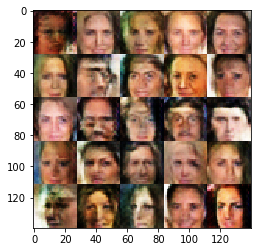

Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.3984
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.3406


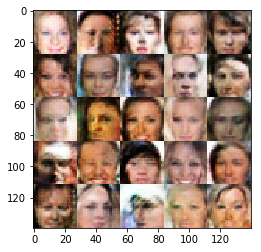

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.6147


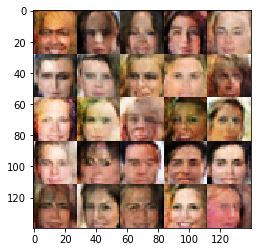

Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6954


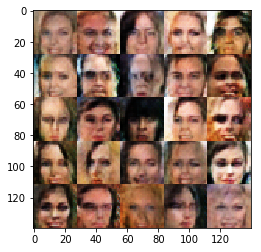

Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.3232
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.3706
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6523


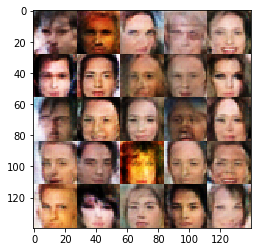

Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7593


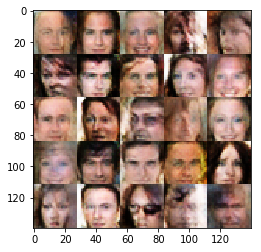

Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.3895
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.8488... Generator Loss: 0.2434


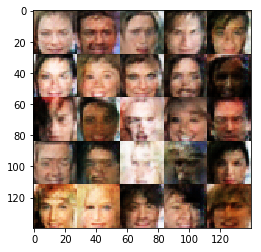

Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 1.4057
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.6476


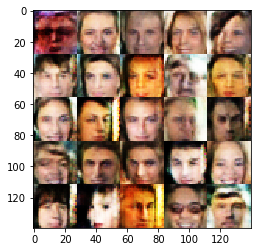

Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.1523
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.8204


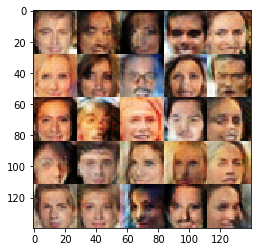

Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.0562


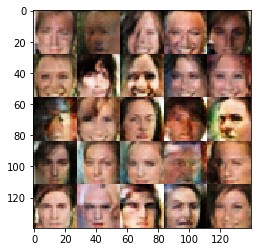

Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8429


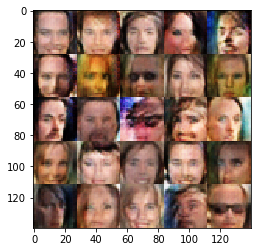

Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 1.3492
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.3890
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.6299


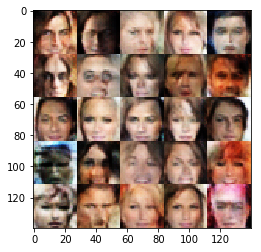

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.7137... Generator Loss: 0.2758
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.4634
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.4146


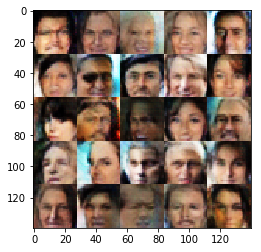

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.7932


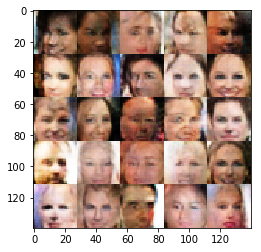

Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.8511


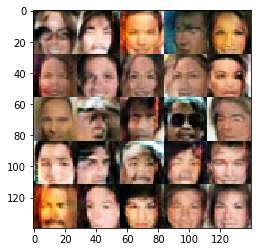

Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.8900... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.7167... Generator Loss: 0.2407
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.5513


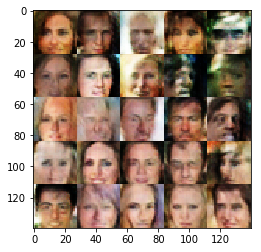

Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.5416


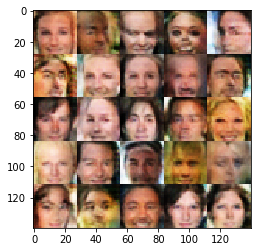

Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 3.3370
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.8710


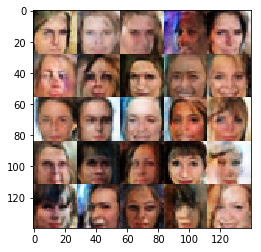

Epoch 1/1... Discriminator Loss: 1.7020... Generator Loss: 0.3262
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.6578


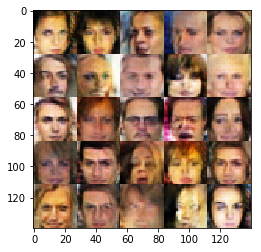

Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.3271
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7566


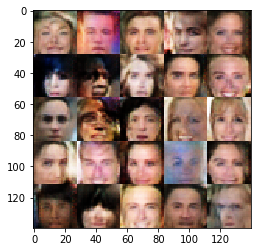

Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.4478
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.8998


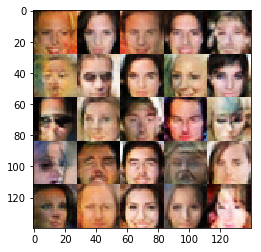

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.2078
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.4764


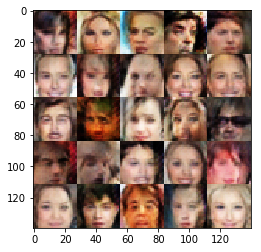

Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7654


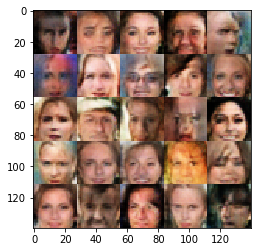

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.7402


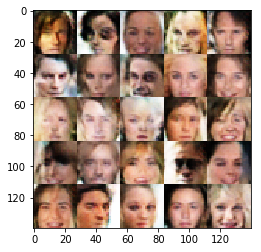

Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8629


In [59]:
batch_size = 32
z_dim = 120
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.